In [4]:
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
from math import log2
%matplotlib inline

Loading Data and some utility functions

In [5]:
def load_clean_data():
    data = sio.loadmat('cleandata_students.mat')
    return data['x'], data['y']

def load_noisy_data():
    data = sio.loadmat('noisydata_students.mat')
    return data['x'], data['y']

Emotions conversion

In [6]:
EMOTIONS = ['anger', 'disgust', 'fear', 'happiness', 'sadness', 'surprise']

def label_to_string(label):
    if label == 1:
        return 'anger'
    elif label == 2:
        return 'disgust'
    elif label == 3:
        return 'fear'
    elif label == 4:
        return 'happiness'
    elif label == 5:
        return 'sadness'
    elif label == 6:
        return 'surprise'
    else:
        return 'Unknown emotion label'

def string_to_label(s):
    if s == 'anger':
        return 1
    elif s == 'disgust':
        return 2
    elif s == 'fear':
        return 3
    elif s == 'happiness':
        return 4
    elif s == 'sadness':
        return 5
    elif s == 'surprise':
        return 6
    else:
        return -1

Auxiliary functions allowing tree training

In [7]:
# turns targets into binary targets depending on the emotion
# the values are of bool type, but it's ok because False == 0 and True ==0
def to_binary_targets(targets, emotion):
    if isinstance(emotion, str):
        emotion = string_to_label(emotion)
    return (targets == emotion).astype(int)

#Checking if binary targets contain of one value (point uniquely to answer)
def all_the_same(bin_targets):
    return np.all(bin_targets == bin_targets[0])

#Returning majority value of binary targets
def majority_value(bin_targets):
    if np.sum(bin_targets) > (bin_targets.size/2):
        return 1
    return 0

#Calculates classification_rate on single tree
def calculate_classification_rate(tree, examples, binary_targets):
    counter=0
    for index in range(0,examples.shape[0]):
        if classify(tree,examples[index],0)[0]==binary_targets[index]:
            counter+=1
    return counter/examples.shape[0]

Decision Tree class

In [8]:
class Tree:
    def __init__(self, op=None, kids=[], classification=None, pos=None, neg=None):
        self.op = op
        self.kids = kids
        self.classification = classification   # tree.class from the specs, but class is a keyword
        self.pos = pos
        self.neg = neg
    def is_leaf(self):
        return (self.classification != None)
    def count_leaves(self):
        if self.is_leaf():
            return 1
        else:
            return self.kids[0].count_leaves() + self.kids[1].count_leaves()

In [9]:
def prune_tree(tree, validation_examples, binary_targets):
    return prune_tree_aux(tree, tree, validation_examples, binary_targets)

def prune_tree_aux(tree, node, validation_examples, binary_targets):
    if not node.kids: # it's a leaf
        return node
    node.kids[0] = prune_tree_aux(tree, node.kids[0], validation_examples, binary_targets)
    node.kids[1] = prune_tree_aux(tree, node.kids[1], validation_examples, binary_targets)
    if node.kids[0].is_leaf() and node.kids[1].is_leaf():
        initial_classification_rate = calculate_classification_rate(tree, validation_examples, binary_targets)
        temp_kids = node.kids
        temp_op = node.op
        node.op = None
        node.kids = []
        
        if node.pos > node.neg:
            node.classification = 1
        else:
            node.classification = 0
        end_classification_rate = calculate_classification_rate(tree, validation_examples, binary_targets)
        
        if end_classification_rate < initial_classification_rate:
            node.classification = None
            node.kids = temp_kids
            node.op = temp_op
    return node

Functions for choosing the decision attribute

In [10]:
#Calculating entropy
def entropy(p, n):
    from math import log
    if p+n == 0: return 0
    a = p/(p+n)
    b = n/(p+n)
    log2 = lambda x: log(x)/log(2)
    if a == 0 or b == 0:
        return 0
    return (-a*log2(a)-b*log2(b))


#Performing IG calculation for given attribute
def attribute_calculation(examples, index, binary_targets):
    p0, n0, p1, n1 = 0, 0, 0, 0
    for x in range(0, binary_targets.size):
        if binary_targets[x] == 0:
            if examples[x][index] == 1:
                n1 += 1
            else:
                n0 += 1
        else:
            if examples[x][index] == 1:
                p1 += 1
            else:
                p0 += 1

    p = np.sum(binary_targets)
    n = binary_targets.size-p

    e1 = entropy(p, n)
    e2 = entropy(p0, n0)
    e3 = entropy(p1, n1)

    remainder = (p0+n0)*e2/(p+n)+(p1+n1)*e3/(p+n)
    return e1 - remainder

#Choosing maximum IG
def choose_best_decision_attribute(examples, attributes, binary_targets, threshold=0):
    index = 0
    max_gain = attribute_calculation(examples, index, binary_targets)
    for x in range (0, attributes.size):
        value = attribute_calculation(examples, x, binary_targets)
        if max_gain < value:
            max_gain = value
            index = x
    if max_gain < threshold:
        return 0
    return attributes[index]

Learning

In [11]:
def decision_tree_learning(examples, attributes, bin_targets, threshold=0):
    if examples.size == 0 or attributes.size == 0:
        return Tree(classification=int(majority_value(bin_targets)), pos=np.sum(bin_targets), neg=bin_targets.size-np.sum(bin_targets))
    elif all_the_same(bin_targets):
        return Tree(classification=int(bin_targets[0]), pos=np.sum(bin_targets), neg=bin_targets.size-np.sum(bin_targets))
    else:
        best_attribute = choose_best_decision_attribute(examples, attributes, bin_targets, threshold)
        if best_attribute == 0:
            return Tree(classification=int(majority_value(bin_targets)), pos=np.sum(bin_targets), neg=bin_targets.size-np.sum(bin_targets))
        index = np.where(attributes==best_attribute)
        index = index[0][0]
        attributes = np.delete(attributes, index)

        ex1 = examples[examples[:,index]==1]
        ex0 = examples[examples[:,index]==0]

        bt1 = bin_targets[examples[:,index]==1]
        bt0 = bin_targets[examples[:,index]==0]

        ex1 = np.delete(ex1,index,axis=1)
        ex0 = np.delete(ex0,index,axis=1)

        t1 = decision_tree_learning(ex1, attributes, bt1, threshold)

        t0 = decision_tree_learning(ex0, attributes, bt0, threshold)

        return Tree(best_attribute, [t1,t0], pos=np.sum(bin_targets), neg=bin_targets.size-np.sum(bin_targets))

Visualization

In [12]:
def tree_width(node):
    if node.is_leaf():
        return 1
    return tree_width(node.kids[0]) + tree_width(node.kids[1])

def tree_height(node):
    if not node:
        return 0
    if not node.kids:
        return 1
    return max(tree_height(node.kids[0]), tree_height(node.kids[1])) + 1

def draw_tree(draw, node, x, y):
    if node.is_leaf():
        draw.text((x-2,y), str(node.classification), (0,0,0))
    else:
        # false is the left branch
        wt = tree_width(node.kids[1]) * 20
        wf = tree_width(node.kids[0]) * 20
        left = x - (wt + wf)/2
        right = x + (wt + wf)/2
        draw.text((x-2,y-1), str(node.op), (0,0,0))
        draw.line((x,y,left+wf/2,y+30), fill=(255,0,0))
        draw.line((x,y,right-wt/2,y+30), fill=(255,0,0))
        draw_tree(draw, node.kids[0], left+wf/2, y+30)
        draw_tree(draw, node.kids[1], right-wt/2, y+30)

def visualize_tree(tree, filename='tree.png'):
    w = tree_width(tree) * 20
    h = tree_height(tree) * 30 + 10
    img = Image.new('RGB', (w,h), (255,255,255))
    draw = ImageDraw.Draw(img)
    draw_tree(draw, tree, w/2, 5)
    img.save(filename,'PNG')
    plt.imshow(img)
    plt.show()

Visualization example

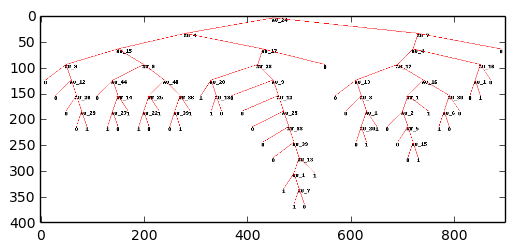

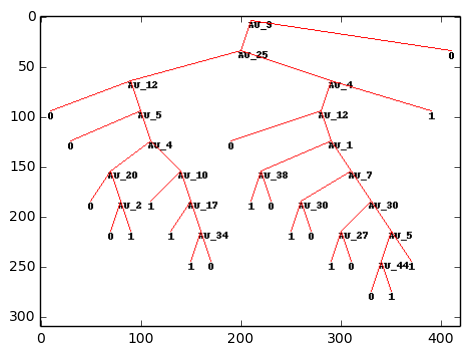

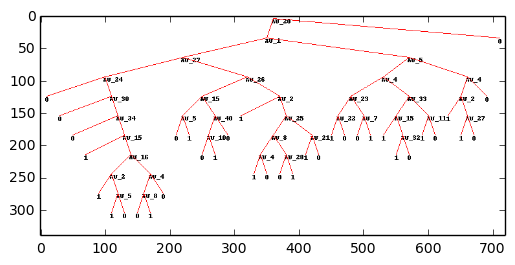

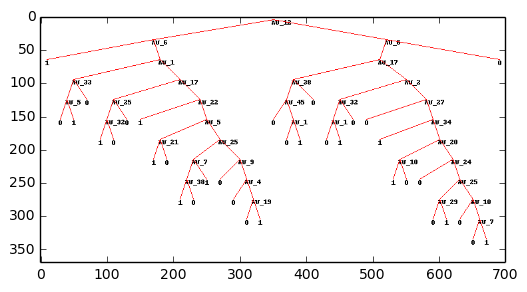

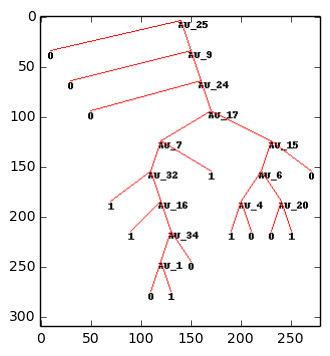

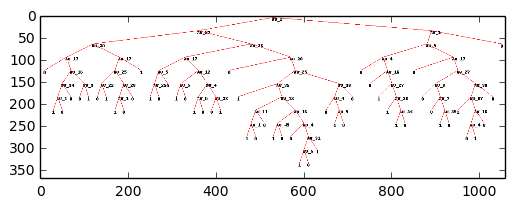

In [13]:
# NOTE: the visualization is saved to tree.jpg file in the directory where this notebook is,
#       it has bigger size
if __name__ == '__main__':
    thresholds = [0.04,0.07,0.05,0.05,0.07,0.04]
    for i in range(6):
        label=i+1
        emotion = label_to_string(label)
        examples, targets = load_clean_data()
        binary_targets = to_binary_targets(targets, emotion)
        attributes = np.array(['AU_' + str(x+1) for x in range(examples.shape[1])])
        tree = decision_tree_learning(examples, attributes, binary_targets,threshold=thresholds[i])
        visualize_tree(tree,'tree_'+label_to_string(i+1)+'.png')

Cross-validation

In [14]:
#Tests one tree, returns depth of classification and classification
def classify(tree, features, depth=0):
    if tree.classification != None:
        return [tree.classification, depth+1]
    if features[tree.op-1]==1:
        return classify(tree.kids[0], features, depth+1)
    else:
        return classify(tree.kids[1], features, depth+1)

# testTrees(T,x2) from the specs, but named test_trees for style
#Tests set of trained trees T on x2
def test_trees(T, x2, random=0):
    L=[]
    for index in range(0,x2.shape[0]):
        depths_pos = []
        out_pos = []
        depths_neg = []
        out_neg = []
        for t_num in range(0,T.size):
            test = classify(T[t_num],x2[index])
            
            if test[0]==1:
                depths_pos.append(test[1])
                out_pos.append(t_num+1)
            else:
                depths_neg.append(test[1])
                out_neg.append(t_num+1)
        if random:
            import random
            if len(out_pos)==0:
                output=random.randint(1, 6)
            else:
                output=out_pos[random.randint(0,len(out_pos)-1)]
        else:
            if len(out_pos)==0:
                output = out_neg[depths_neg.index(max(depths_neg))]
            else:
                output = out_pos[depths_pos.index(min(depths_pos))]
        L.append(output)
    return L

Confusion matrix

In [15]:
#Creating confusion matrix

def confusion_matrix_10_cross(examples, targets, threshold=[0,0,0,0,0,0], prune=0,random=0):
    k = 10
    N = len(targets)
    foldN = N // k
    confusion_matrix = np.zeros((6,6), dtype=np.int)

    #i = ith cross-validation run
    for i in range(k):
        aux_x = np.vstack((examples[:i*foldN, :], examples[(i+1)*foldN:, :]))
        aux_y = np.vstack((targets[:i*foldN, :], targets[(i+1)*foldN:, :]))
        if prune:
            import random
            valid_fold = random.randint(0,k-4)
            train_x = np.vstack((aux_x[:valid_fold*foldN, :], aux_x[(valid_fold+3)*foldN:, :]))
            train_y = np.vstack((aux_y[:valid_fold*foldN, :], aux_y[(valid_fold+3)*foldN:, :]))
            valid_x = aux_x[valid_fold*foldN:(valid_fold+3)*foldN, :]
            valid_y = aux_y[valid_fold*foldN:(valid_fold+3)*foldN, :]
        else:
            train_x=aux_x
            train_y=aux_y
            
        test_x = examples[i*foldN:(i+1)*foldN, :]
        test_y = targets[i*foldN:(i+1)*foldN, :]
        
        attributes = np.arange(1, examples.shape[1]+1)

        #Training on train data
        L=[]
        for i in range(1,7):
            tree = decision_tree_learning(train_x, attributes, to_binary_targets(train_y,i), threshold[i-1])
            if prune:
                tree = prune_tree(tree, valid_x, to_binary_targets(valid_y,i))
            L.append(tree)
        T = np.array(L)

        results = test_trees(T, test_x, random)

        for i in range(0, test_y.size):
            confusion_matrix[test_y[i] - 1, results[i] - 1]+=1
            
    return confusion_matrix

Model accuracy depending on threshold

[ 0.    0.01  0.02  0.03  0.04  0.05  0.06  0.07  0.08  0.09  0.1   0.11
  0.12  0.13  0.14  0.15  0.16  0.17  0.18  0.19]
[ 0.75   0.757  0.768  0.784  0.79   0.795  0.79   0.778  0.734  0.71
  0.707  0.701  0.687  0.633  0.615  0.616  0.615  0.602  0.59   0.572]
[ 0.25   0.243  0.232  0.216  0.21   0.205  0.21   0.222  0.266  0.29
  0.293  0.299  0.313  0.367  0.385  0.384  0.385  0.398  0.41   0.428]


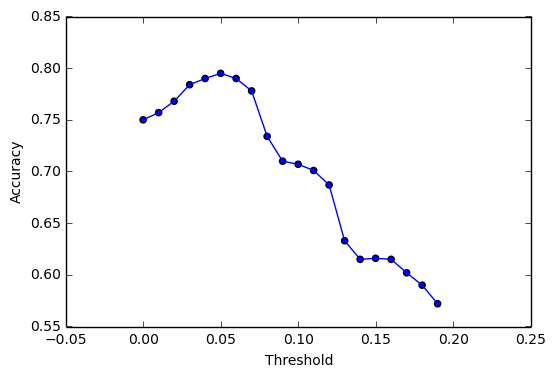

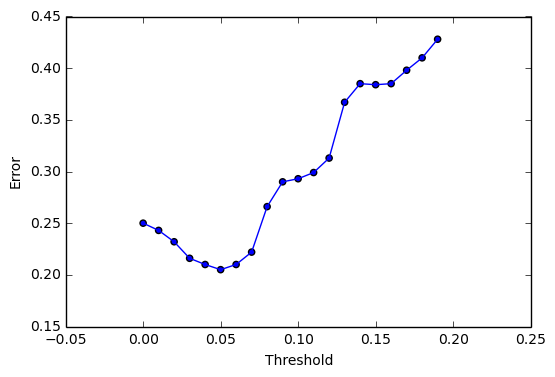

In [13]:
if __name__ == '__main__':
    xs = []
    ys = []
    er = []
    x, y = load_clean_data()
    
    for i in range(20):
        cm = confusion_matrix_10_cross(x,y,prune=0,threshold=[i*0.01,i*0.01,i*0.01,i*0.01,i*0.01,i*0.01])
        xs.append(i*0.01)
        ys.append((cm[0,0]+cm[1,1]+cm[2,2]+cm[3,3]+cm[4,4]+cm[5,5])/np.sum(cm))
        er.append(1-ys[i])
    xs=np.array(xs)
    ys=np.array(ys)
    er=np.array(er)
    print(xs)
    print(ys)
    print(er)
    import matplotlib.pyplot as plt
       
    plt.scatter(xs,ys)
    plt.plot(xs,ys)
    plt.ylabel('Accuracy')
    plt.xlabel('Threshold')
    plt.savefig('figure.png')
    plt.show()
    plt.clf()
    
    plt.scatter(xs,er)
    plt.plot(xs,er)
    plt.ylabel('Error')
    plt.xlabel('Threshold')
    plt.savefig('figure2.png')
    plt.show()

In [14]:
'''
# TODO : delete this code
def test_trees(trees, examples):
    res = []
    for i,example in enumerate(examples):
        max_d = 0
        max_e = 0
        for j,tree in enumerate(trees):
            (c, d) = classify(tree, example)
            if c and max_d < d:
                max_d = d
                max_e = j+1
        res.append([(max_e)])
    return np.array(res)
    
def get_precision(predTargets, trueTargets):
    return np.sum(predTargets == trueTargets) / predTargets.size
    
# k-fold validation
def k_fold_validation(examples, targets, k, prune=False):
    N = len(examples)
    foldN = N // k
    precs = []
    for i in range(k):
        print('Fold ' + str(i))
        training_examples = np.vstack((examples[:i*foldN, :], examples[(i+1)*foldN:, :]))
        training_targets = np.vstack((targets[:i*foldN, :], targets[(i+1)*foldN:, :]))
        validation_examples = np.array([])
        validation_targets = np.array([])
        if prune:
            T = len(training_examples)
            validation_examples = training_examples[:(T//(k-1))]
            validation_targets  = training_targets[:(T//(k-1))]
            training_examples = training_examples[(T//(k-1)):]
            training_targets = training_targets[(T//(k-1)):]
        test_examples = examples[i*foldN:(i+1)*foldN, :]
        test_targets = targets[i*foldN:(i+1)*foldN, :]
        trees = []
        for emotion in EMOTIONS:
            print('  emotion = ' + emotion)
            #attributes = np.array(['AU_' + str(x+1) for x in range(examples.shape[1])])
            attributes = np.array(list(range(1, examples.shape[1]+1)))
            binary_training_targets = to_binary_targets(training_targets, emotion)
            tree = decision_tree_learning(training_examples, attributes, binary_training_targets)
            if prune:
                tree = prune_tree(tree, validation_examples, validation_targets)
            trees.append(tree)
        predictions = test_trees(trees, test_examples)
        #print(predictions)
        precision = get_precision(predictions, test_targets)
        print(precision)
        precs.append(precision)
    print('PRECISION = ' + str(np.mean(np.array(precs))))
'''

"\n# TODO : delete this code\ndef test_trees(trees, examples):\n    res = []\n    for i,example in enumerate(examples):\n        max_d = 0\n        max_e = 0\n        for j,tree in enumerate(trees):\n            (c, d) = classify(tree, example)\n            if c and max_d < d:\n                max_d = d\n                max_e = j+1\n        res.append([(max_e)])\n    return np.array(res)\n    \ndef get_precision(predTargets, trueTargets):\n    return np.sum(predTargets == trueTargets) / predTargets.size\n    \n# k-fold validation\ndef k_fold_validation(examples, targets, k, prune=False):\n    N = len(examples)\n    foldN = N // k\n    precs = []\n    for i in range(k):\n        print('Fold ' + str(i))\n        training_examples = np.vstack((examples[:i*foldN, :], examples[(i+1)*foldN:, :]))\n        training_targets = np.vstack((targets[:i*foldN, :], targets[(i+1)*foldN:, :]))\n        validation_examples = np.array([])\n        validation_targets = np.array([])\n        if prune:\n   

Crossvalidation of one tree

In [21]:
# TODO : this is not used, delete later
def crossvalidate_tree(examples, targets, emotion, threshold=0, random=0):
    k = 10
    N = len(targets)
    foldN = N // k
    precision=[]
    #i = ith cross-validation run
    for i in range(k):
        train_x = np.vstack((examples[:i*foldN, :], examples[(i+1)*foldN:, :]))
        train_y = np.vstack((targets[:i*foldN, :], targets[(i+1)*foldN:, :]))
                   
        test_x = examples[i*foldN:(i+1)*foldN, :]
        test_y = targets[i*foldN:(i+1)*foldN, :]
        
        attributes = np.arange(1, examples.shape[1]+1)

        #Training on train data
        tree = decision_tree_learning(train_x, attributes, to_binary_targets(train_y,emotion), threshold)
        
        counter = 0
        for i in range(test_y.size):
            if classify(tree, test_x[i])[0]==to_binary_targets(test_y,emotion)[i]:
                counter+=1
        precision.append(counter/test_y.size)
        

    return sum(precision)/len(precision)

In [25]:
def classification_rate_from_confusion_matrix(cm):
    if cm.shape[0] != cm.shape[1]:
        print('ERROR: confusion matrix should be a square matrix')
        return -1
    temp = 0
    for i in range(cm.shape[0]):
        temp += cm[i,i]
    return temp/np.sum(cm)

# returns an array with precision per class
def precision_from_confusion_matrix(cm):
    if cm.shape[0] != cm.shape[1]:
        print('ERROR: confusion matrix should be a square matrix')
        return -1
    res = []
    for i in range(cm.shape[0]):
        temp = 0
        for j in range(cm.shape[0]):
            temp += cm[j,i]
        res.append(cm[i,i]/temp)
    return np.array(res)

# returns an array with recall per class
def recall_from_confusion_matrix(cm):
    if cm.shape[0] != cm.shape[1]:
        print('ERROR: confusion matrix should be a square matrix')
        return -1
    res = []
    for i in range(cm.shape[0]):
        temp = 0
        for j in range(cm.shape[0]):
            temp += cm[i,j]
        res.append(cm[i,i]/temp)
    return np.array(res)

def f1_from_confusion_matrix(cm):
    precisions = precision_from_confusion_matrix(cm)
    recalls = recall_from_confusion_matrix(cm)
    return np.array(list((2*p*r)/(p+r) for (p,r) in zip(precisions, recalls)))

In [26]:
if __name__ == '__main__':
    
    x, y = load_clean_data()
         
    print('== Model with optimized thresholds, selection depending on depth ==')
    cm = confusion_matrix_10_cross(x,y,prune=0,threshold=[0.04,0.07,0.05,0.05,0.07,0.04])
    print(cm)
    print('Classification rate: ' + str(classification_rate_from_confusion_matrix(cm)))
    print('Precision per class: ' + str(precision_from_confusion_matrix(cm)))
    print('Recall per class: ' + str(recall_from_confusion_matrix(cm)))
    print('F1 per class: ' + str(f1_from_confusion_matrix(cm)))
    print('===')
    print()
    
    print('== Model with no thresholds, selection depending on depth ==')
    cm = confusion_matrix_10_cross(x,y,prune=0)
    print(cm)
    print('Classification rate: ' + str(classification_rate_from_confusion_matrix(cm)))
    print('Precision per class: ' + str(precision_from_confusion_matrix(cm)))
    print('Recall per class: ' + str(recall_from_confusion_matrix(cm)))
    print('F1 per class: ' + str(f1_from_confusion_matrix(cm)))
    print('===')
    print()
    
    print('== Model with no thresholds, random selection ==')
    cm = confusion_matrix_10_cross(x,y,prune=0,random=1)
    print(cm)
    print('Classification rate: ' + str(classification_rate_from_confusion_matrix(cm)))
    print('Precision per class: ' + str(precision_from_confusion_matrix(cm)))
    print('Recall per class: ' + str(recall_from_confusion_matrix(cm)))
    print('F1 per class: ' + str(f1_from_confusion_matrix(cm)))
    print('===')

== Model with optimized thresholds, selection depending on depth ==
[[106   6   3   4  11   1]
 [ 15 163   2   5  11   2]
 [  3   4  90   3   2  16]
 [  0   7   0 200   3   5]
 [ 20  12   5   8  74  13]
 [  2   6  12   6   5 175]]
Classification rate: 0.808
Precision per class: [ 0.7260274   0.82323232  0.80357143  0.88495575  0.69811321  0.8254717 ]
Recall per class: [ 0.80916031  0.82323232  0.76271186  0.93023256  0.56060606  0.84951456]
F1 per class: [ 0.76534296  0.82323232  0.7826087   0.90702948  0.62184874  0.83732057]
===

== Model with no thresholds, selection depending on depth ==
[[ 89  19   4   4  13   2]
 [ 18 150   1  10  12   7]
 [  4   6  88   3   3  14]
 [  1  12   3 183  11   5]
 [ 25  16   7   8  72   4]
 [  3   5  15   6   9 168]]
Classification rate: 0.75
Precision per class: [ 0.63571429  0.72115385  0.74576271  0.85514019  0.6         0.84      ]
Recall per class: [ 0.67938931  0.75757576  0.74576271  0.85116279  0.54545455  0.81553398]
F1 per class: [ 0.6568265